# Visualizing Wyvern Data
This notebook details the code & process for visualizing Wyvern data. 

More details can be found on our Knowledge Centre at the following link:

https://knowledge.wyvern.space/#/using_wyvern_data/python/python.md

> **Note:** There are many ways to visualize raster data using Python. The combination of Rasterio + Matplotlib was chosen due to the simplicity & ability to build off of this code.

## Getting started
- Ensure you have installed Anaconda/Conda
- Build the environment for this notebook using the following command:
  ```
   conda env create -f environment.yml
  ```
- Run this notebook in your tool of choice (Jupyter Lab, Visual Studio Code, etc), making sure you run it with the conda environment you just created!

## Image we're using
Check out the image on the [Wyvern Open Data Catalog](https://opendata.wyvern.space/#/year/2024/wyvern_dragonette-001_20240930T070744_08fd7f5a/wyvern_dragonette-001_20240930T070744_08fd7f5a.json)!

## Band Combinations
We'll be exploring the following band combinations!

| Name | Red Channel | Green Channel | Blue Channel |
| ---- | ----------- | ------------- | ------------ |
| Natural Color (RGB) | 650nm | 550nm | 503nm |
| Color Infrared (CIR) | 750nm | 650nm | 550nm |

In [16]:
# First, let's import our required packages
import requests
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Feel free to modify the image that is downloaded in this section
DOWNLOAD_IMAGE = True  # Change to False if you have already downloaded the image!
STAC_ITEM = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/year/2024/wyvern_dragonette-001_20240930T070744_08fd7f5a/wyvern_dragonette-001_20240930T070744_08fd7f5a.json"
LOCAL_FILE_NAME = "wyvern_dragonette-001_20240930T070744_08fd7f5a.tiff"
NAN_VALUE = -9999  # Default NaN value for Wyvern L1B geotiffs

In [35]:
# Let's define some useful functions we'll use to generate pretty imagery
# We use python typing to define the dtypes that this function intakes & outputs.
def min_max_normalize(arr: np.ndarray) -> np.ndarray:
    """Wyvern L1B data is Top-of-Atmosphere Radiance. These values
    are out of the range that matplotlib is expecting. We need to scale
    our image values to 0-1 or 0-255. This function does this, as well
    as replacing the NaN value (-9999) with an actual NaN value.

    Args:
        arr (np.ndarray): Input array requiring scaling

    Returns:
        np.ndarray: Scaled output array w/ NaN's added
    """
    arr = np.where(arr == NAN_VALUE, np.nan, arr)
    # nanmin/nanmax ignore NaN values within an array while still calculating the value (max, min)
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))

In [45]:
# We're going to use the Python Requests library to download our image. Since it's a large image,
# we'll use streaming/chunking to write the file directly to disk instead of holding it in memory.
# Feel free to not run this cell if you have already downloaded the data.
print("Loading STAC Item!")
stac_item_response = requests.get(STAC_ITEM)
stac_item_response.raise_for_status()  # Will raise an error if we have any issues getting the STAC item
stac_item = stac_item_response.json()
print(f"Successfully loaded STAC Item!\nSTAC Item ID: {stac_item['id']}")

download_url = stac_item["assets"]["Cloud optimized GeoTiff"]["href"]
local_file_name = download_url.split("/")[-1]
print(
    f"Downloading GeoTIFF from STAC Metadata!\nDownload url: {download_url}]\n"
    f"Downloading to local file named: {local_file_name}"
)

if DOWNLOAD_IMAGE:
    with requests.get(download_url, stream=True) as r:
        r.raise_for_status()
        with open(local_file_name, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
print("Download completed!")

In [31]:
# Now, let's load in our downloaded image & print some metadata about the image.
image_file = rasterio.open(LOCAL_FILE_NAME)
image_arr = image_file.read()

print(f"Image shape: {image_arr.shape}")
print(f"Image bands: {', '.join(image_file.descriptions)}")

Image shape: (23, 8271, 6013)
Image bands: Band_503, Band_510, Band_519, Band_535, Band_549, Band_570, Band_584, Band_600, Band_614, Band_635, Band_649, Band_660, Band_669, Band_679, Band_690, Band_699, Band_711, Band_722, Band_734, Band_750, Band_764, Band_782, Band_799


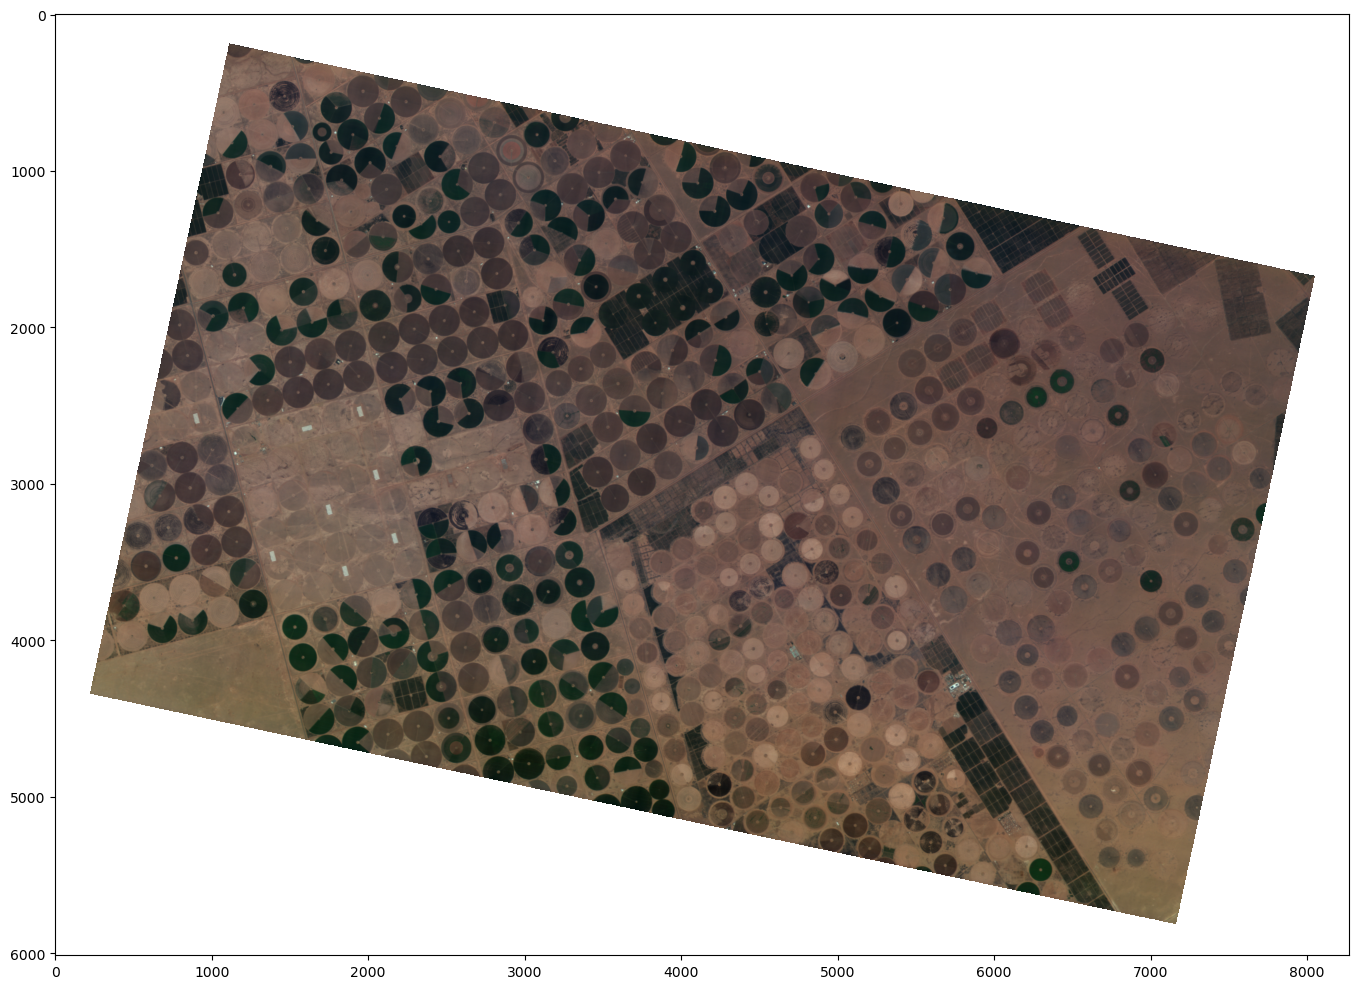

In [43]:
# First, we select our R, G, and B channels from our hyperspectral image array, and then we shift the array shape
# from [BAND, X, Y] to [X, Y, Band] which matplotlib is expected
rgb_arr = image_arr[[10, 4, 0], :, :].swapaxes(0, -1)

# Then we can normalize our image and plot the result!
# We specify a larger figsize to get a better resolution out of the image. You can
# increase this further to further improve resolution! (at the expense of file size)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(min_max_normalize(rgb_arr))

# For fun, let's also export this as an image!
plt.tight_layout()
plt.savefig("wyvern_rgb.png")

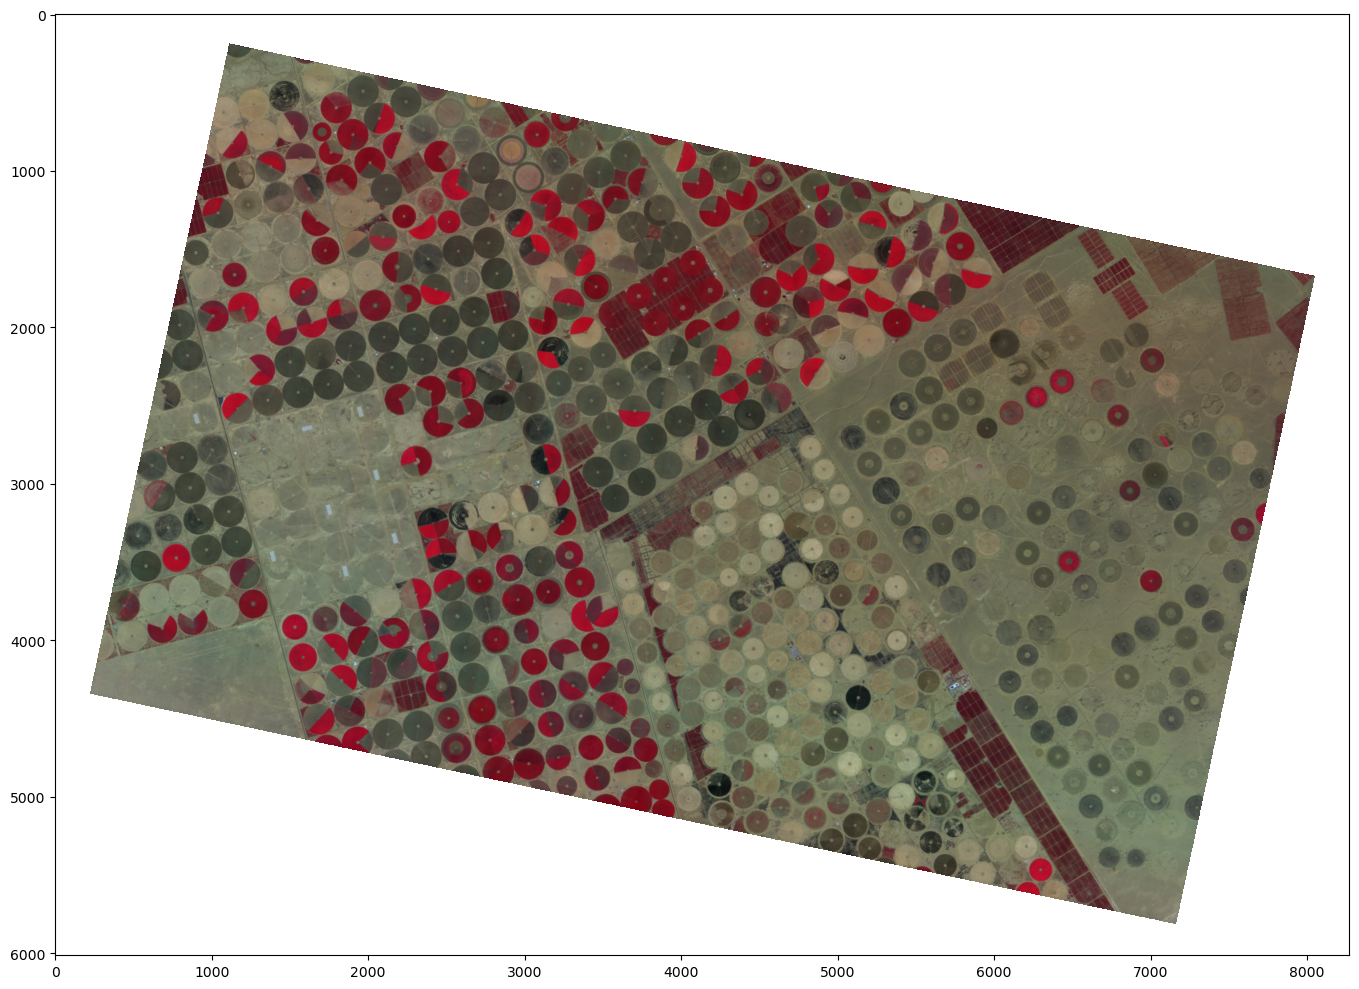

In [44]:
# Now, let's do the same with color infrared!
cir_arr = image_arr[[19, 10, 4], :, :].swapaxes(0, -1)

# Then we can normalize our image and plot the result!
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(min_max_normalize(cir_arr))

# For fun, let's also export this as an image!
plt.tight_layout()
plt.savefig("wyvern_cir.png")

Well done! You now know how to download and view Wyvern images in Python!